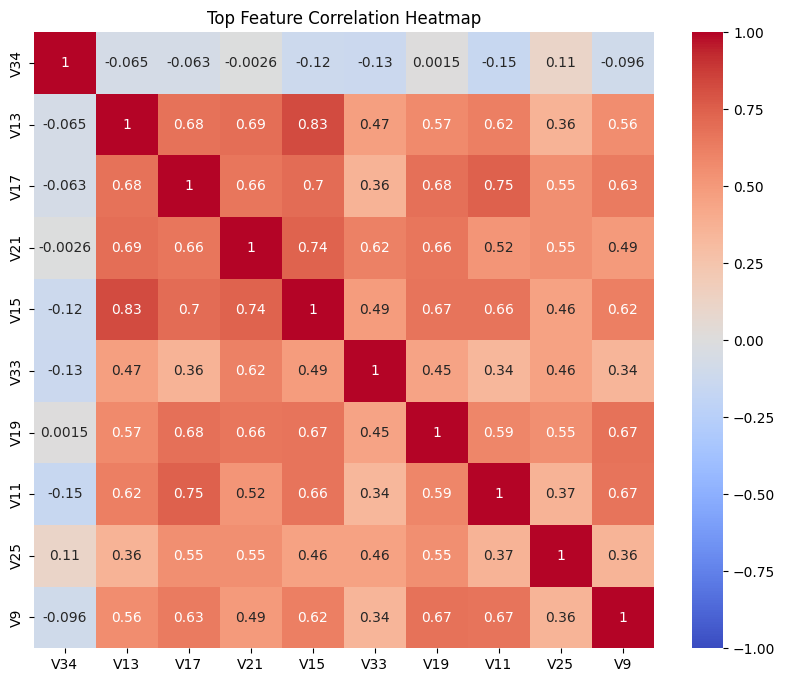

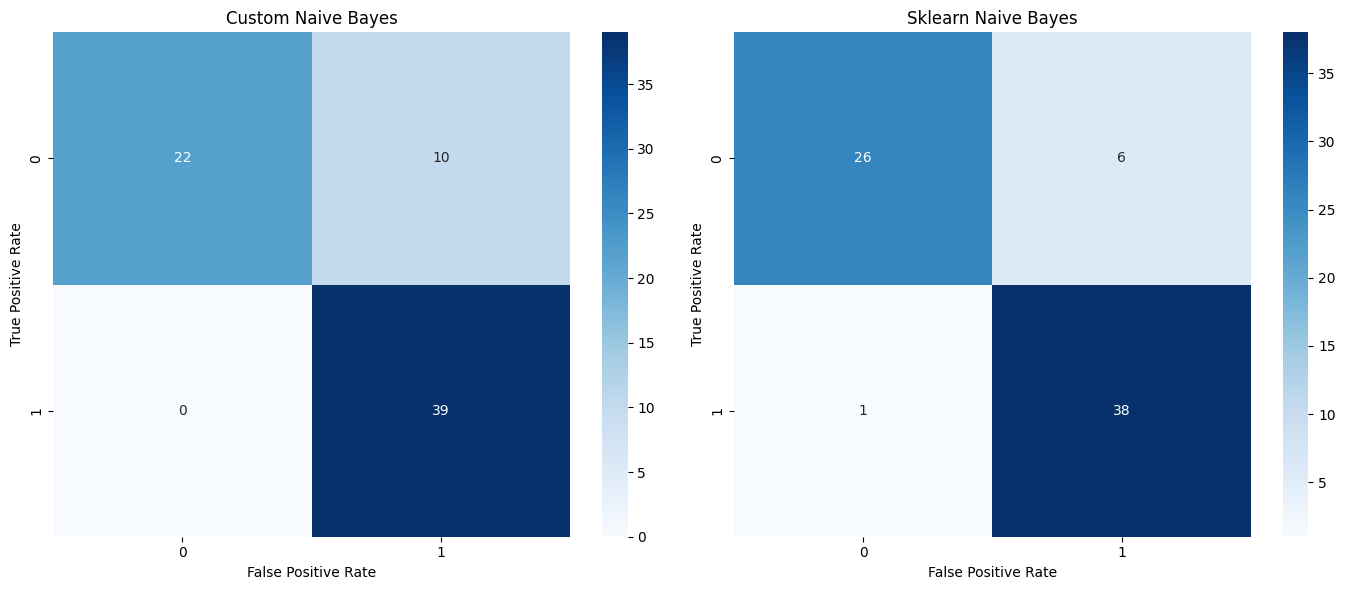

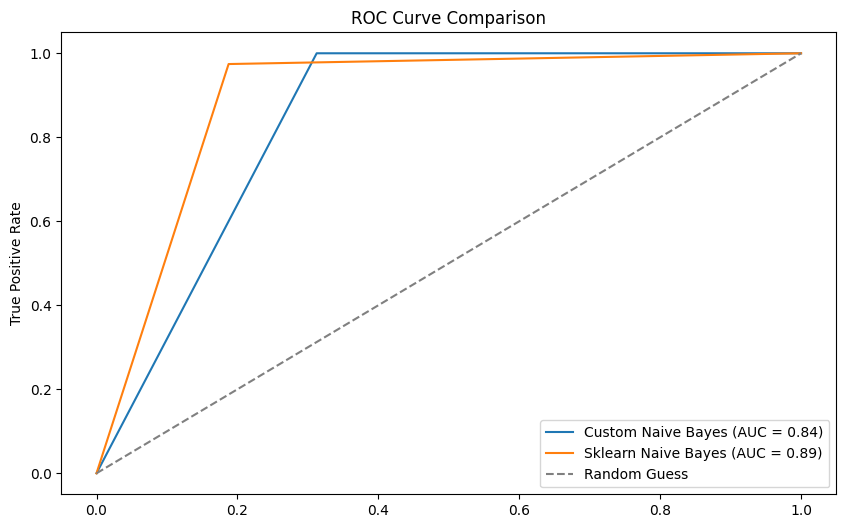

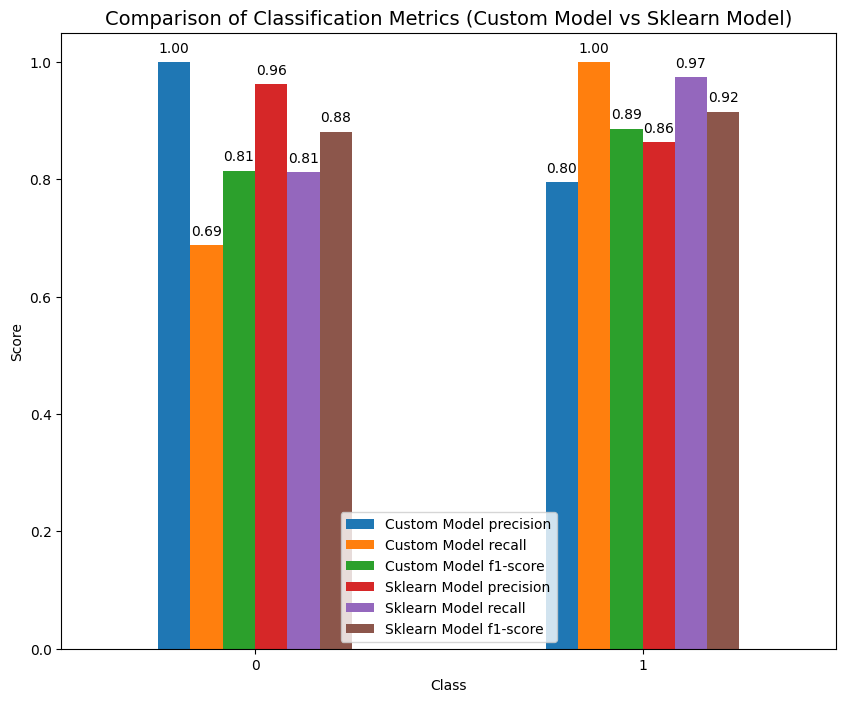

<Figure size 600x700 with 0 Axes>

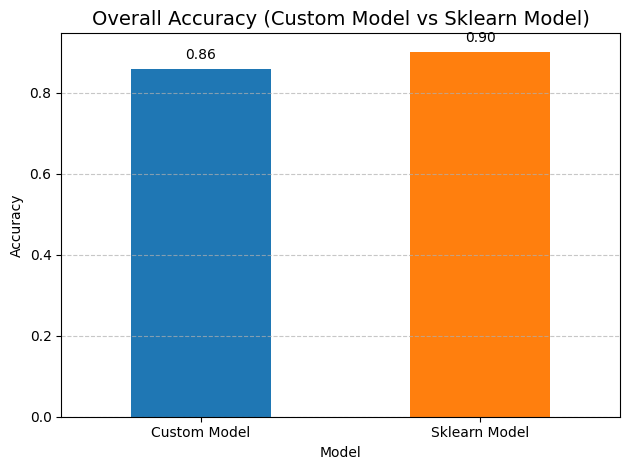

In [3]:
from time import time
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)


# Custom Gaussian Naive Bayes implementation
class CustomGaussianNB:
    def __init__(self):
        self.summaries = None
        self.classes = None

    # Split the dataset by class values, returns a dictionary
    def separate_by_class(self, dataset):
        separated = dict()
        for i in range(len(dataset)):
            vector = dataset[i]
            class_value = vector[-1]
            if class_value not in separated:
                separated[class_value] = list()
            separated[class_value].append(vector)
        return separated

    # Calculate the mean
    def mean(self, numbers):
        return np.mean(numbers, axis=0)

    # Calculate the standard deviation
    def stdev(self, numbers):
        return np.std(numbers, axis=0, ddof=1)

    # Summarize the dataset
    def summarize_dataset(self, dataset):
        summaries = [
            (self.mean(column), self.stdev(column), len(column))
            for column in zip(*dataset)
        ]
        del summaries[-1]
        return summaries

    # Summarize data by class
    def summarize_by_class(self, dataset):
        separated = self.separate_by_class(dataset)
        summaries = dict()
        for class_value, rows in separated.items():
            summaries[class_value] = self.summarize_dataset(rows)
        return summaries

    # Fit the model
    def fit(self, X, y):
        dataset = np.column_stack((X, y))
        self.summaries = self.summarize_by_class(dataset)
        self.classes = np.unique(y)

    # Gaussian probability distribution
    def calculate_probability(self, x, mean, stdev):
        if stdev == 0:
            stdev = stdev + 1e-6
        exponent = np.exp(-((x - mean) ** 2 / (2 * stdev**2)))
        return (1 / (np.sqrt(2 * pi) * stdev)) * exponent

    # Calculate class probabilities
    def calculate_class_probabilities(self, summaries, row):
        total_rows = sum([summaries[label][0][2] for label in summaries])
        probabilities = dict()
        for class_value, class_summaries in summaries.items():
            probabilities[class_value] = class_summaries[0][2] / float(total_rows)
            for i in range(len(class_summaries)):
                mean, stdev, _ = class_summaries[i]
                probabilities[class_value] *= self.calculate_probability(
                    row[i], mean, stdev
                )
        return probabilities

    # Predict class for a single row
    def predict_row(self, row):
        probabilities = self.calculate_class_probabilities(self.summaries, row)
        best_label, best_prob = None, -1
        for class_value, probability in probabilities.items():
            if best_label is None or probability > best_prob:
                best_prob = probability
                best_label = class_value
        return best_label

    # Predict Modal
    def predict(self, X):
        return np.array([self.predict_row(row) for row in X])

    # Predict Probabilities
    def predict_proba(self, X):
        return np.array(
            [self.calculate_class_probabilities(self.summaries, row) for row in X]
        )


# Load data set here and doing required changes like converting good to `1` and bad to `0` and removing `Unnamed: 0` and updated values to numeric
data = pd.read_csv("./data/ION_Binary_Classification.csv")
data = data.drop(columns=["Unnamed: 0"])
data["Class"] = data["Class"].map({"good": 1, "bad": 0})
data.iloc[:, :-1] = data.iloc[:, :-1].apply(pd.to_numeric, errors="coerce")

# Split data into train and test
X = data.drop(columns=["Class"])
Y = data["Class"]
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=80
)

corr_matrix = X.corr()
top_corr_features = (
    corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
)
top_features = (
    top_corr_features[top_corr_features > 0.5].index.get_level_values(0).unique()[:10]
)
plt.figure(figsize=(10, 8))
sns.heatmap(X[top_features].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Top Feature Correlation Heatmap")
plt.show()

# Custom Naive Bayes
custom_nb = CustomGaussianNB()
start_time_custom = time()
custom_nb.fit(X_train.values, Y_train.values)
y_pred_custom = custom_nb.predict(X_test.values)
end_time_custom = time()
custom_train_time = end_time_custom - start_time_custom

# Sklearn Naive Bayes
sklearn_nb = GaussianNB()
start_time_sklearn = time()
sklearn_nb.fit(X_train, Y_train)
y_pred_sklearn = sklearn_nb.predict(X_test)
end_time_sklearn = time()
sklearn_train_time = end_time_sklearn - start_time_sklearn

# Metrics for Custom Model
metrics_custom = classification_report(Y_test, y_pred_custom, output_dict=True)
roc_auc_custom = roc_auc_score(Y_test, y_pred_custom)
confusion_matrix_custom = confusion_matrix(Y_test, y_pred_custom)
df_metrics_custom = pd.DataFrame(metrics_custom).transpose()

# Metrics for Sklearn Model
metrics_sklearn = classification_report(Y_test, y_pred_sklearn, output_dict=True)
roc_auc_sklearn = roc_auc_score(Y_test, y_pred_sklearn)
confusion_matrix_sklearn = confusion_matrix(Y_test, y_pred_sklearn)
df_metrics_sklearn = pd.DataFrame(metrics_sklearn).transpose()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Heatmap for custom Naive Bayes
sns.heatmap(
    confusion_matrix(Y_test, y_pred_custom), annot=True, cmap="Blues", ax=axes[0]
)
axes[0].set_title("Custom Naive Bayes")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
# Heatmap for Sklearn Naive Bayes
sns.heatmap(
    confusion_matrix(Y_test, y_pred_sklearn), annot=True, cmap="Blues", ax=axes[1]
)
axes[1].set_title("Sklearn Naive Bayes")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
plt.tight_layout()
plt.show()

fpr_custom, tpr_custom, _ = roc_curve(Y_test, y_pred_custom)
fpr_sklearn, tpr_sklearn, _ = roc_curve(Y_test, y_score=y_pred_sklearn)

plt.figure(figsize=(10, 6))
sns.lineplot(
    x=fpr_custom, y=tpr_custom, label=f"Custom Naive Bayes (AUC = {roc_auc_custom:.2f})"
)
sns.lineplot(
    x=fpr_sklearn,
    y=tpr_sklearn,
    label=f"Sklearn Naive Bayes (AUC = {roc_auc_sklearn:.2f})",
)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("ROC Curve Comparison")
plt.show()

df_combined = pd.concat(
    [df_metrics_custom, df_metrics_sklearn],
    axis=1,
    keys=["Custom Model", "Sklearn Model"],
)
df_metrics = df_combined.drop(
    columns=[("Custom Model", "support"), ("Sklearn Model", "support")]
)
df_metrics.columns = [
    "Custom Model " + col for col in ["precision", "recall", "f1-score"]
] + ["Sklearn Model " + col for col in ["precision", "recall", "f1-score"]]
df_filtered = df_metrics.loc[
    ["0", "1"]
]  # Or ['0', '1'] for binary class classification
custom_accuracy = df_combined.loc["accuracy", ("Custom Model", "precision")]
sklearn_accuracy = df_combined.loc["accuracy", ("Sklearn Model", "precision")]
df_accuracy = pd.DataFrame(
    {
        "Model": ["Custom Model", "Sklearn Model"],
        "Accuracy": [custom_accuracy, sklearn_accuracy],
    }
)
ax = df_filtered.plot(kind="bar", figsize=(10, 8))
plt.title(
    "Comparison of Classification Metrics (Custom Model vs Sklearn Model)", fontsize=14
)
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=0)
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )
plt.figure(figsize=(6, 7))
ax2 = df_accuracy.plot(
    kind="bar", x="Model", y="Accuracy", legend=False, color=["#1f77b4", "#ff7f0e"]
)
plt.title("Overall Accuracy (Custom Model vs Sklearn Model)", fontsize=14)
plt.ylabel("Accuracy")
plt.xticks(rotation=0)
for p in ax2.patches:
    ax2.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()